## Imorting Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts.models import NBEATSModel, TCNModel, RNNModel, TransformerModel
from darts import TimeSeries
from darts.metrics import mae, mse, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from pytorch_lightning import Trainer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
import warnings
import joblib
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
custom_palette = sns.color_palette("coolwarm", n_colors=10)
sns.set_palette(custom_palette)

Importing plotly failed. Interactive plots will not work.


#### [Dataset Link](https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset)

### Data Exploration

In [2]:
data = pd.read_csv("retail_store_inventory.csv")

In [3]:
data.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [5]:
data.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [6]:
data.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

### Initial Data Preprocessing

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

##### In this cell we convert the values in the 'Date' column of the data to get proper datetime objects.

In [8]:
data.set_index('Date', inplace=True)

##### In this code we sets the 'Date' column as the index of the data DataFrame. By applying this, 'Date' values become the row labels which will help to improve efficiency of time based operation.

In [9]:
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

##### In this cell we convert categorical columns into dummy variables.

In [10]:
scaler = MinMaxScaler()
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

##### In this cell we normalize the numerical features in the data. It identifies numerical columns (Float, int), this applies to calculate the values between 0 to 1 and then updates the dataframe with transformed values.

## Exploratory Data Analysis

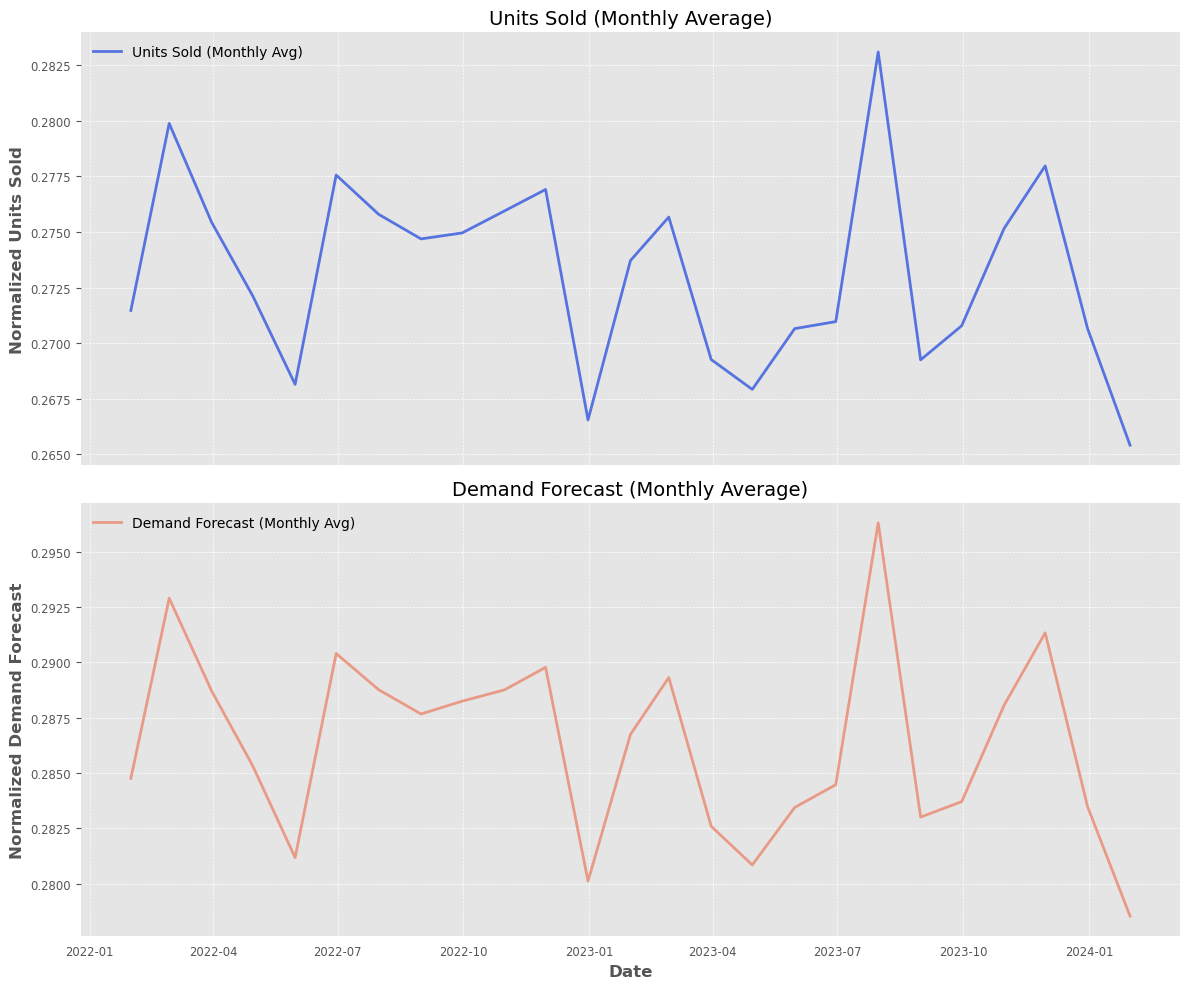

In [11]:
monthly_data = data.resample('M').mean()
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(monthly_data.index, monthly_data['Units Sold'], label='Units Sold (Monthly Avg)', color=custom_palette[0], linewidth=2)
axes[0].set_title('Units Sold (Monthly Average)', fontsize=14)
axes[0].set_ylabel('Normalized Units Sold', fontsize=12)
axes[0].legend(fontsize=10, loc='upper left')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

axes[1].plot(monthly_data.index, monthly_data['Demand Forecast'], label='Demand Forecast (Monthly Avg)', color=custom_palette[8], alpha=0.7, linewidth=2)
axes[1].set_title('Demand Forecast (Monthly Average)', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Normalized Demand Forecast', fontsize=12)
axes[1].legend(fontsize=10, loc='upper left')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

##### We resample the data to a monthly frequency and calculate monthly average of each column. Then we create two subplots to plot 'Units Sold' and 'Demand Forecast'. For each subplot we plottted data series, customize the titles, labels, and grid settings and adjust the appearance such as line color and width.

##### In the output "Units Sold" plot, some fluctuation in the data showing peaks and valleys over time, which likely indicate the variation in units sold across in different months. Same as in "Demand Forecast" plot also shows fluctuations, but the overall trend shows to be different from the units sold. These plots help us to compare the trends in between actual sales and forecasted demand,

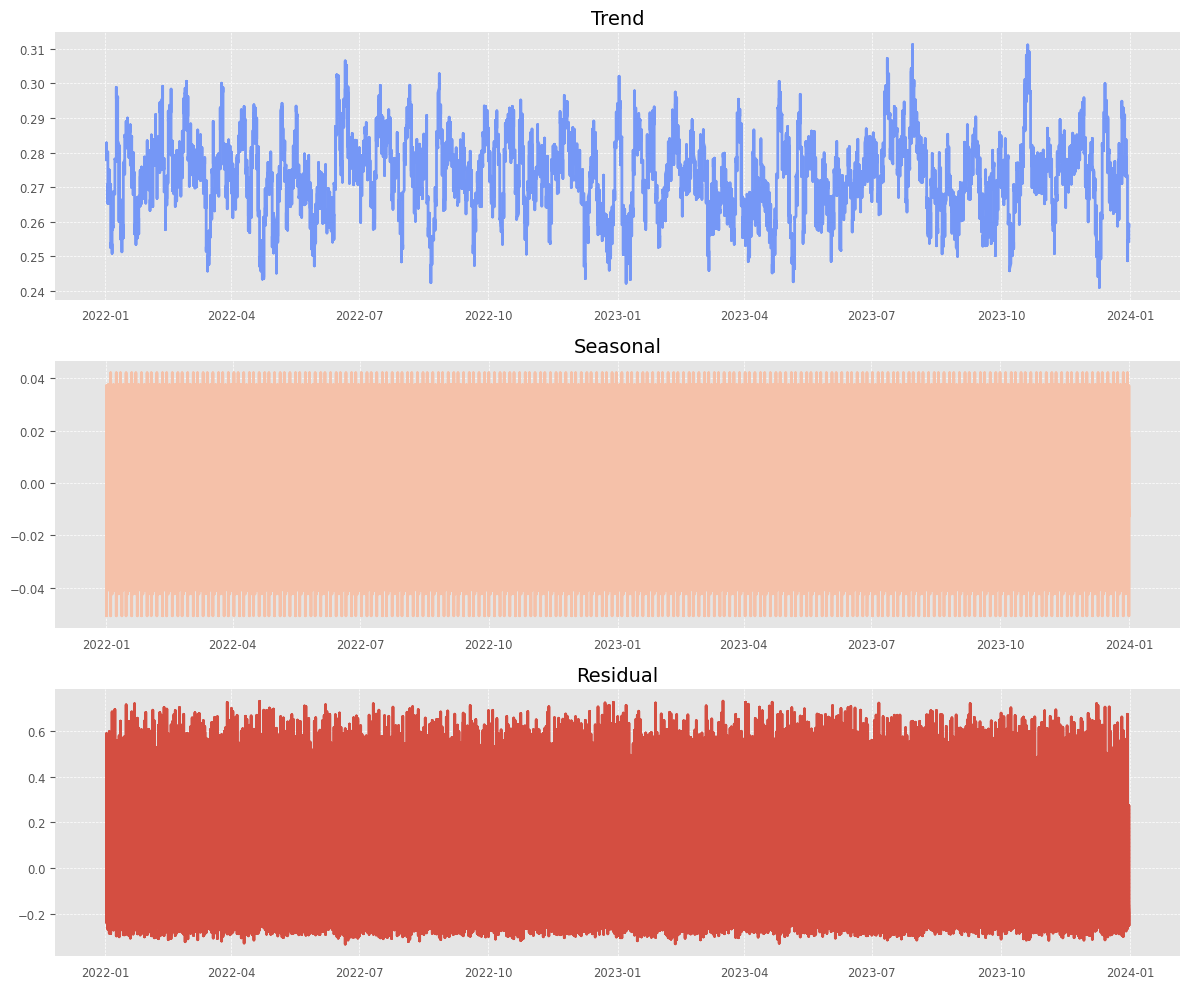

In [12]:
result = seasonal_decompose(data['Units Sold'], model='additive', period=365)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(result.trend, color=custom_palette[1], linewidth=2)
axes[0].set_title('Trend', fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=0.5)

axes[1].plot(result.seasonal, color=custom_palette[6], linewidth=2)
axes[1].set_title('Seasonal', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)

axes[2].plot(result.resid, color=custom_palette[9], linewidth=2)
axes[2].set_title('Residual', fontsize=14)
axes[2].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

##### In the code, we have seasonal_decompose function to the 'Units Sold' column of the DataFrame to decompose the time series into three components- trend, seasonal, and residual and set period to 365 to show us yearly seasonality. After that, we make three subplots to visualize these components.

##### From the plot, we can see that the trend component shows periodic changes, which tells us that there are variations and activity remains mostly stable over time. The stability tells us that there is regular pattern in data. The seasonal component also shows flat and consistent behavior. This shows a predictable cycle is in the data that may reflect business patterns. But, the trend component has noticeable spread and irregularity which tells us that there is some noise in the data and it can contain some unpredictable elements. This elements should be refined for better prediction accuracy.

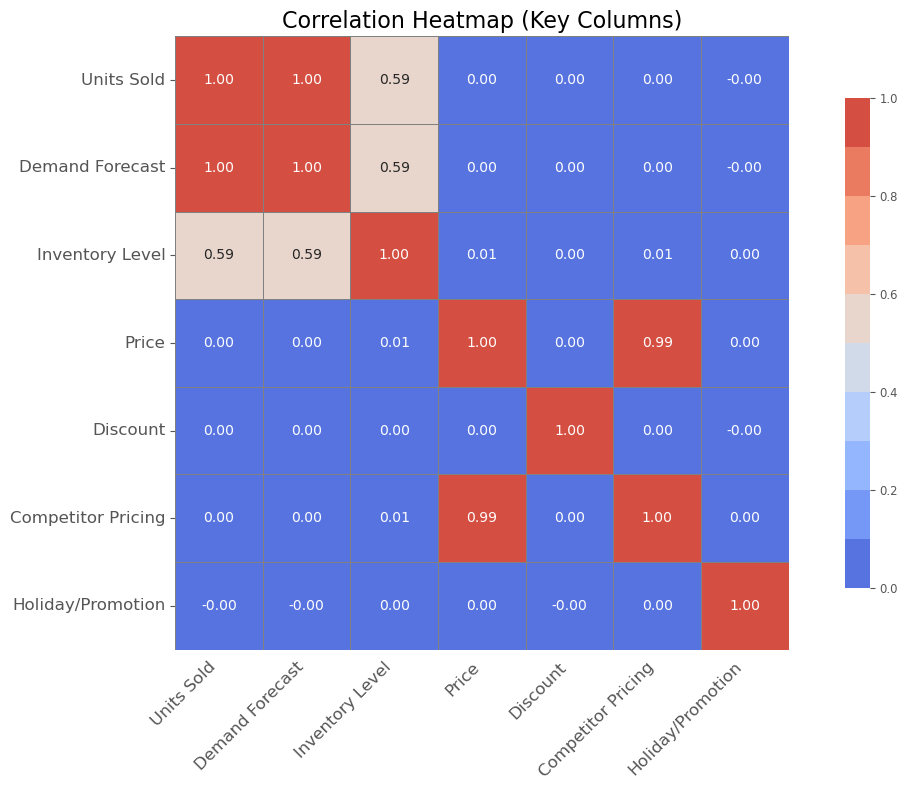

In [13]:
key_columns = ['Units Sold', 'Demand Forecast', 'Inventory Level', 'Price', 'Discount', 'Competitor Pricing', 'Holiday/Promotion']
plt.figure(figsize=(12, 8))
sns.heatmap(data[key_columns].corr(), annot=True, cmap=custom_palette, fmt='.2f', cbar_kws={'shrink': 0.8}, linewidths=0.5, linecolor='gray', square=True)
plt.title('Correlation Heatmap (Key Columns)', fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

##### In this cell we analyze the correlation and we create heatmap to visualize the correlation matrix of these selected columns. Lastly, we plotted the heatmap to help to understand the relationships between the key variables. 

##### From the matrix, we can see a perfect positive correlation between 'Units Sold' and 'Demand Forecast' which indicates that forecasted demand matches with real sales. While 'Inventory Level' shows medium correlation with both 'Units Sold' and 'Demand Forecast'. But 'Discount' and 'Hoilday/Promotion' have very less correlation with most of the factors.

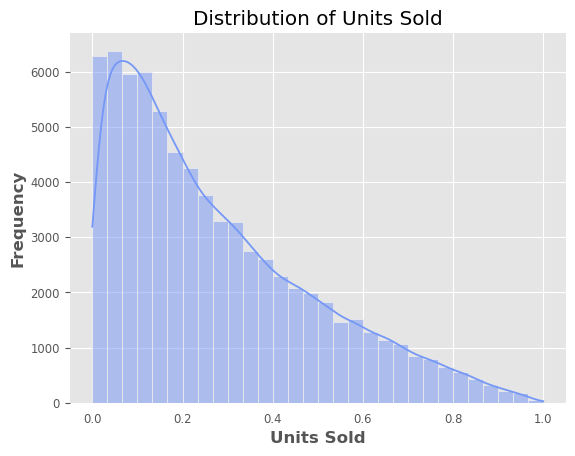

In [14]:
sns.histplot(data['Units Sold'], kde=True, bins=30, color=custom_palette[1])
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

##### In this cell we created a histogram of the Units Sold data with a kernel density estimate (KDE) to show the distribution of the data. we set a bins 30 and lastly, display the Boxplot, which helps us to visualize the frequency distribution of the 'Units Sold' values.

### Outlier Analysis

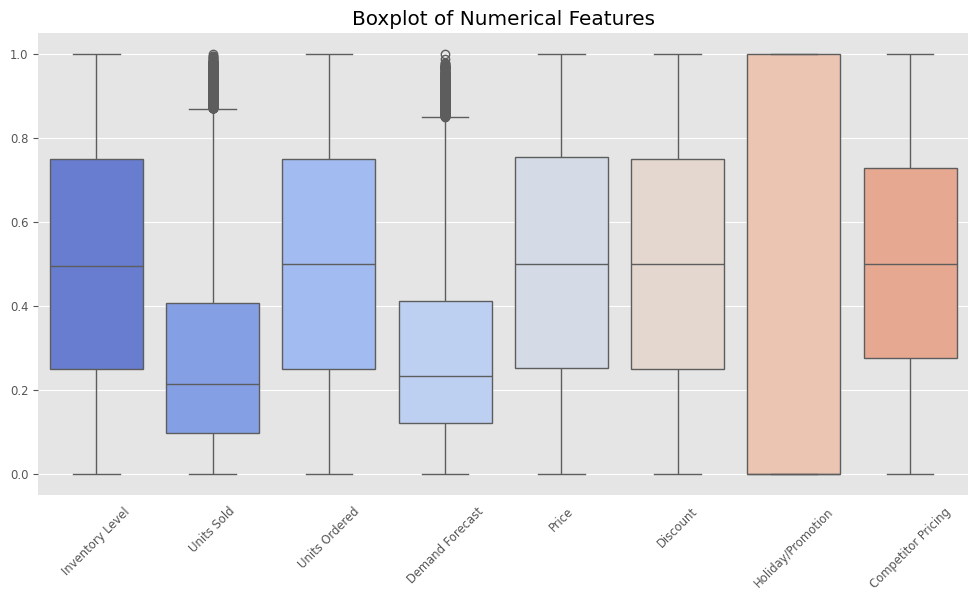

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numerical_cols], palette=custom_palette)
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)
plt.show()

##### In this cell, we have plotted a box plot to analyse the outliers in the main columns from the dataset. From the plot we can see that there are some outliers in 'Units Sold' and  'Demand Forecast' columns.

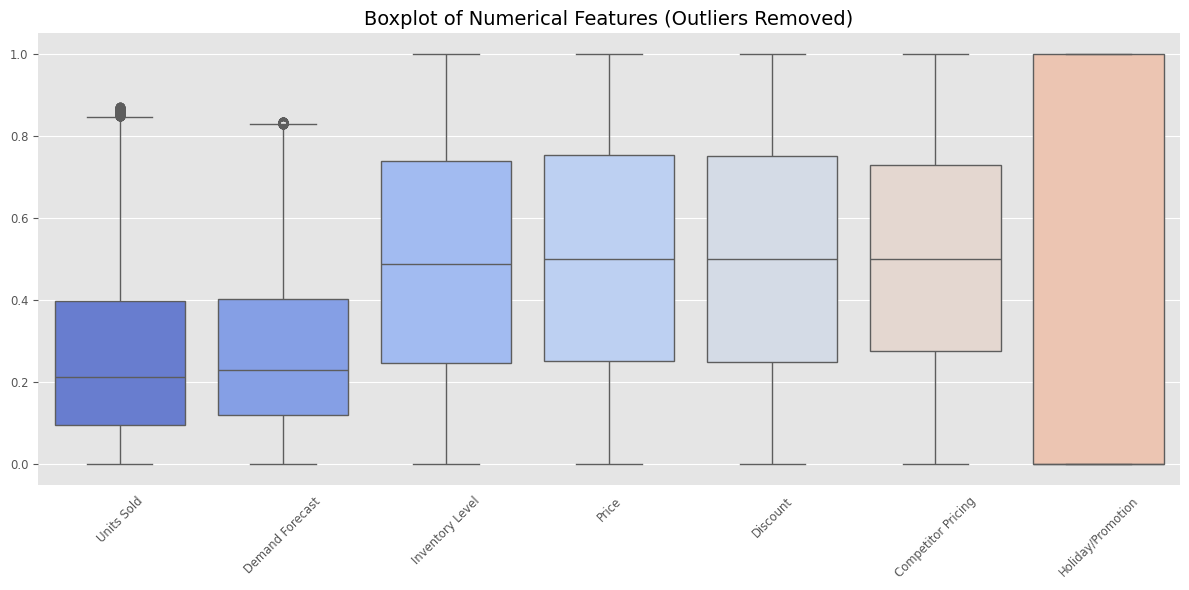

In [16]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

data = remove_outliers(data, key_columns)

plt.figure(figsize=(12, 6))
sns.boxplot(data=data[key_columns], palette=custom_palette)
plt.title('Boxplot of Numerical Features (Outliers Removed)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### We used the IQR methode to remove the outliers because it is efficient, proven and most important it preserves the data integrity. It focuses on the moddle 50% of data which helps minimize the influence of extreme values. This makes it particularly effective for datasets with vatiability like supply chain data. We have appled the 1.5 multiplier which is widely used thershold in data science. This helps to identify meaningful outliers and avoid unnecessary adjustments to valid data points.This method ensures that extreme values are capped rather than removed. This method prevents machine learning models from being skewed or overfitting to extreme values which results in stable and reliable predictions.

### Time Series Analysis

In [17]:
data['Units Sold Differenced'] = data['Units Sold'] - data['Units Sold'].shift(1)
data_differenced = data['Units Sold Differenced'].dropna()

adf_result_diff = adfuller(data_differenced)
print("\nADF Statistic (Differenced):", adf_result_diff[0])
print("p-value (Differenced):", adf_result_diff[1])
print("Critical Values (Differenced):")
for key, value in adf_result_diff[4].items():
    print(f"\t{key}: {value}")


ADF Statistic (Differenced): -58.167753868276975
p-value (Differenced): 0.0
Critical Values (Differenced):
	1%: -3.4304407272978072
	5%: -2.8615800998730396
	10%: -2.5667913437890526


##### We calculate the difference in consecutive values in the Units Sold column to eliminate any lingering trends and seasonality effects, thus ensuring that there is a resultant stationary series. The differenced time series is then subjected to an application of the ADF test: this is in an intent to statistically ensure that any series is indeed stationary prior to time series modeling/forecasting. The outputs from R include the ADF statistic  to arrive at that conclusion.

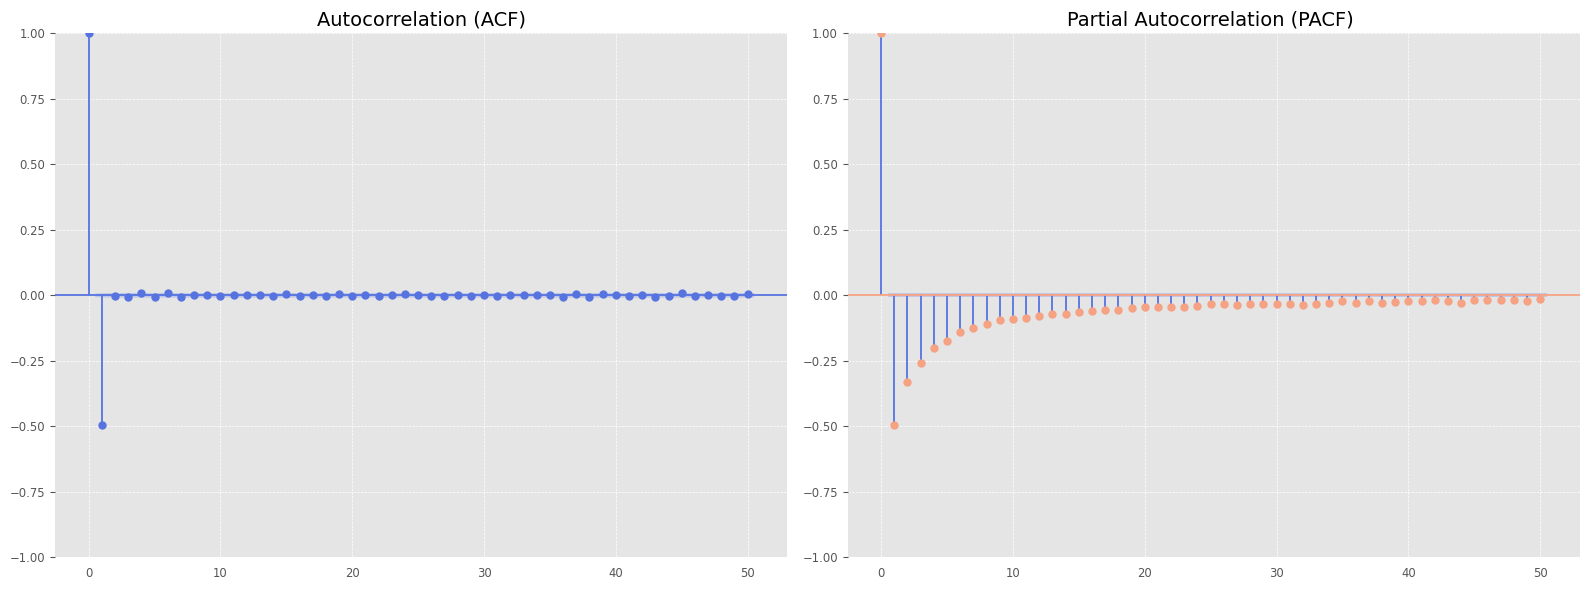

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(data_differenced, ax=axes[0], lags=50, color=custom_palette[0])
axes[0].set_title('Autocorrelation (ACF)', fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=0.5)

plot_pacf(data_differenced, ax=axes[1], lags=50, color=custom_palette[7])
axes[1].set_title('Partial Autocorrelation (PACF) ', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

##### The ACF plot presents a sharp decline after lag 1, indicating, therefore, that the said correlation rapidly decreases as there is an increase in lag. The PACF, on the other hand, at lag 1 presents a larger spike, while the preceding values gradually taper off. This potentially suggests an AR(1) process. Further analysis for this would thus point out possibly that the time series could easily be modeled by a simpler method like ARIMA or autoregressive.

## Feature Engineering

In [19]:
data['Month'] = data.index.month
data['Day'] = data.index.day
data['Week'] = data.index.isocalendar().week
data['Year'] = data.index.year

##### Here we extracted month, day, week, and year from the dataset's date index to capture seasonal and temporal patterns, enhancing analysis and model performance.

In [20]:
data['Lag_1'] = data['Units Sold'].shift(1)
data['Lag_7'] = data['Units Sold'].shift(7)
data['Lag_30'] = data['Units Sold'].shift(30)

##### In this cell we created lag features for the "Units Sold" column by shifting the data by 1, 7, and 30 days. This helps capture short-term, weekly, and monthly trends, improving the model's ability to understand temporal dependencies.

In [21]:
data['Rolling_Mean_7'] = data['Units Sold'].rolling(window=7).mean()
data['Rolling_Std_7'] = data['Units Sold'].rolling(window=7).std()
data['Rolling_Mean_30'] = data['Units Sold'].rolling(window=30).mean()
data['Rolling_Std_30'] = data['Units Sold'].rolling(window=30).std()

##### Here we calculated rolling statistics for the "Units Sold" column using 7-day and 30-day windows. The rolling mean captures average sales trends over these periods, while the rolling standard deviation identifies fluctuations. These features enhance the model's understanding of local trends and variability in the data.

In [22]:
data = data.dropna()

In [23]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

##### As this time series dataset, we splited the dataset into training and testing sets by allocating 80% of the data to train and the remaining 20% to test. This separation ensures the model is trained on historical data and evaluated on unseen data validate its performance and prevent overfitting.

In [24]:
train = train[~train.index.duplicated(keep='first')]
test = test[~test.index.duplicated(keep='first')]
train = train.asfreq('D')  
test = test.asfreq('D')

def fill_missing(series):
    return series.fillna(method='ffill').fillna(method='bfill')

train['Units Sold'] = fill_missing(train['Units Sold'])
test['Units Sold'] = fill_missing(test['Units Sold'])

##### First, we removed any duplicate entries in the indices, retaining only the first occurrence. Then, we set the frequency of both datasets to daily ('D') to ensure uniformity in the time series. To address missing values in the Units Sold column, we apply forward filling (ffill) to propagate the last valid observation, followed by backward filling (bfill) to fill remaining gaps. 

In [25]:
ts_train = TimeSeries.from_dataframe(train, value_cols="Units Sold", fill_missing_dates=True, freq='D').astype(np.float32)
ts_test = TimeSeries.from_dataframe(test, value_cols="Units Sold", fill_missing_dates=True, freq='D').astype(np.float32)

##### Here we have prepared the training and testing datasets for time series analysis using the Darts library. These datasets are created by converting the train and test DataFrames into TimeSeries objects, specifying the Units Sold column as the target variable. Missing dates are automatically filled to maintain consistent time intervals, with a daily frequency ('D').

In [26]:
train_rf_xgb = train.drop(columns=['Units Sold']).copy()
test_rf_xgb = test.drop(columns=['Units Sold']).copy()
categorical_cols = train_rf_xgb.select_dtypes(include=['category', 'object']).columns

if 'Week' in train_rf_xgb.columns:
    train_rf_xgb['Week'] = pd.factorize(train_rf_xgb['Week'])[0]
    test_rf_xgb['Week'] = pd.factorize(test_rf_xgb['Week'])[0]

if not categorical_cols.empty:
    train_rf_xgb = pd.get_dummies(train_rf_xgb, columns=categorical_cols)
    test_rf_xgb = pd.get_dummies(test_rf_xgb, columns=categorical_cols)

train_rf_xgb, test_rf_xgb = train_rf_xgb.align(test_rf_xgb, join='left', axis=1)
test_rf_xgb = test_rf_xgb.fillna(0)

##### In this cell we prepare the feature datasets for Random Forest and XGBoost Models. After dropping Units Sold, we handle categorical columns by encoding Week with integers and applying one-hot encoding to others. The training and testing sets are aligned to ensure consistent features, with missing columns in the test set filled with zeros.

In [27]:
results = {}

##### Here we have defined a dictionary to record the results of each model, which will be used after the training process to display the results of all models

## Model Training

### Random Forest Regressor

In [28]:
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
best_rf_score = float("inf")
best_rf_params = None
for params in ParameterGrid(rf_param_grid):
    print(f"Training Random Forest with params: {params}")
    rf_model = RandomForestRegressor(**params, random_state=42)
    rf_model.fit(train_rf_xgb, train['Units Sold'])
    rf_predictions = rf_model.predict(test_rf_xgb)
    rf_score = mean_absolute_error(test['Units Sold'], rf_predictions)

    if rf_score < best_rf_score:
        best_rf_score = rf_score
        best_rf_params = params

print(f"Random Forest Best Params: {best_rf_params}, MAE: {best_rf_score}")
results['Random Forest'] = {"Best Params": best_rf_params, "MAE": best_rf_score}

Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Training Random Forest with params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training 

##### We decided to go with the Random Forest model as the first model because it can handle a large amount of data, including both numerical and categorical features, making it really useful for capturing complex patterns with its ensemble learning method. This choice also assures us that overfitting will not be a problem because this method provides an average of multiple trees. The concrete ranges of the hyperparameters were based on usual tuning practices.

##### n_estimators=[50, 100, 200]: Controls the number of trees, providing a balance between accuracy and computational efficiency.

##### max_depth=[None, 10, 20]: Controls the complexity of each tree to avoid overfitting without underfitting the data.

##### min_samples_split=[2, 5, 10] and min_samples_leaf=[1, 2, 4] ensure that tree splits and their leaf sizes are meaningful to assure better generalization on unseen data.

##### These values were informed by research and best practices, offering enough flexibility for optimization while remaining computationally feasible for our dataset and goals. We then sought to systematically explore this grid in search of the combination that achieves optimal predictive performance.


### XGBoost Model

In [29]:
xgb_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "tree_method": ["hist"]  # Specify tree_method explicitly
}
best_xgb_score = float("inf")
best_xgb_params = None
for params in ParameterGrid(xgb_param_grid):
    print(f"Training XGBoost with params: {params}")
    xgb_model = XGBRegressor(**params, random_state=42, enable_categorical=True)
    xgb_model.fit(train_rf_xgb, train['Units Sold'])
    xgb_predictions = xgb_model.predict(test_rf_xgb)
    xgb_score = mean_absolute_error(test['Units Sold'], xgb_predictions)

    if xgb_score < best_xgb_score:
        best_xgb_score = xgb_score
        best_xgb_params = params

print(f"XGBoost Best Params: {best_xgb_params}, MAE: {best_xgb_score}")
results['XGBoost'] = {"Best Params": best_xgb_params, "MAE": best_xgb_score}

Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0, 'tree_method': 'hist'}
Training XGBoost with params: {'colsample_bytree': 0.8, 'lea

##### We chose the XGBoost model as our second model for its ability to handle complex datasets efficiently, providing high accuracy with faster computation through gradient-boosted decision trees. This model excels in dealing with both categorical and numerical data, making it ideal for our dataset. The hyperparameter grid was carefully designed to balance model complexity and computational cost.

##### n_estimators [50, 100, 200]: Determines the number of boosting rounds; smaller values prevent overfitting while larger values ensure robust learning.

##### max_depth [3, 6, 10]: Controls tree depth, balancing underfitting for shallow trees and overfitting for deeper ones.

##### learning_rate [0.01, 0.1, 0.2]: Affects the step size in gradient updates; lower values allow for gradual optimization, while higher values converge faster.

##### subsample [0.8, 1.0]: Prevents overfitting by sampling a fraction of data for training each tree.

##### colsample_bytree [0.8, 1.0]: Regulates the fraction of features considered for splitting, promoting diversity in trees and reducing overfitting.

##### tree_method ["hist"]: Optimized for efficiency in large datasets, using a histogram-based split finding algorithm.

##### The hyperparameter ranges were informed by XGBoost's documentation and literature, balancing generality with dataset-specific needs. By iterating through combinations, we aimed to find the optimal set of parameters for minimizing mean absolute error while maintaining scalability and adaptability. This tuning ensures the model aligns with our objective of creating robust predictive insights for inventory and demand forecasting.

### NBeats Model

In [30]:
nbeats_param_grid = {
    "input_chunk_length": [30, 60],
    "output_chunk_length": [7, 14],
    "num_stacks": [2, 3],
    "num_blocks": [1, 2, 3],
    "layer_widths": [128, 256, 512]
}
best_nbeats_score = float("inf")
best_nbeats_params = None
for params in ParameterGrid(nbeats_param_grid):
    print(f"Training N-BEATS with params: {params}")
    nbeats_model = NBEATSModel(**params, random_state=42, n_epochs=50)
    nbeats_model.fit(ts_train)
    nbeats_predictions = nbeats_model.predict(len(ts_test))
    nbeats_score = mae(ts_test, nbeats_predictions)

    if nbeats_score < best_nbeats_score:
        best_nbeats_score = nbeats_score
        best_nbeats_params = params

print(f"N-BEATS Best Params: {best_nbeats_params}, MAE: {best_nbeats_score}")
results['N-BEATS'] = {"Best Params": best_nbeats_params, "MAE": best_nbeats_score}

Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 7}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 110 K  | train
-------------------------------------------------------------
109 K     Trainable params
825       Non-trainable params
110 K     Total params
0.440     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 110 K  | train
-------------------------------------------------------------
109 K     Trainable params
825       Non-trainable params
110 K     Total params
0.440     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 165 K  | train
-------------------------------------------------------------
164 K     Trainable params
825       Non-trainable params
165 K     Total params
0.660     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 165 K  | train
-------------------------------------------------------------
164 K     Trainable params
825       Non-trainable params
165 K     Total params
0.661     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 220 K  | train
-------------------------------------------------------------
219 K     Trainable params
825       Non-trainable params
220 K     Total params
0.880     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 220 K  | train
-------------------------------------------------------------
219 K     Trainable params
825       Non-trainable params
220 K     Total params
0.881     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 330 K  | train
-------------------------------------------------------------
329 K     Trainable params
825       Non-trainable params
330 K     Total params
1.320     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 330 K  | train
-------------------------------------------------------------
329 K     Trainable params
825       Non-trainable params
330 K     Total params
1.321     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 330 K  | train
-------------------------------------------------------------
329 K     Trainable params
825       Non-trainable params
330 K     Total params
1.320     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 330 K  | train
-------------------------------------------------------------
329 K     Trainable params
825       Non-trainable params
330 K     Total params
1.321     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 495 K  | train
-------------------------------------------------------------
494 K     Trainable params
825       Non-trainable params
495 K     Total params
1.981     Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 495 K  | train
-------------------------------------------------------------
494 K     Trainable params
825       Non-trainable params
495 K     Total params
1.982     Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 128, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 416 K  | train
-------------------------------------------------------------
414 K     Trainable params
1.5 K     Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 416 K  | train
-------------------------------------------------------------
414 K     Trainable params
1.5 K     Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 624 K  | train
-------------------------------------------------------------
622 K     Trainable params
1.5 K     Non-trainable params
624 K     Total params
2.497     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 624 K  | train
-------------------------------------------------------------
622 K     Trainable params
1.5 K     Non-trainable params
624 K     Total params
2.498     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 832 K  | train
-------------------------------------------------------------
830 K     Trainable params
1.5 K     Non-trainable params
832 K     Total params
3.330     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 832 K  | train
-------------------------------------------------------------
831 K     Trainable params
1.5 K     Non-trainable params
832 K     Total params
3.330     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.2 M  | train
-------------------------------------------------------------
1.2 M     Trainable params
1.5 K     Non-trainable params
1.2 M     Total params
4.994     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.2 M  | train
-------------------------------------------------------------
1.2 M     Trainable params
1.5 K     Non-trainable params
1.2 M     Total params
4.996     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.2 M  | train
-------------------------------------------------------------
1.2 M     Trainable params
1.5 K     Non-trainable params
1.2 M     Total params
4.994     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.2 M  | train
-------------------------------------------------------------
1.2 M     Trainable params
1.5 K     Non-trainable params
1.2 M     Total params
4.996     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.9 M  | train
-------------------------------------------------------------
1.9 M     Trainable params
1.5 K     Non-trainable params
1.9 M     Total params
7.492     Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.9 M  | train
-------------------------------------------------------------
1.9 M     Trainable params
1.5 K     Non-trainable params
1.9 M     Total params
7.493     Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 256, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
2.7 K     Non-trainable params
1.6 M     Total params
6.474     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
2.7 K     Non-trainable params
1.6 M     Total params
6.474     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.4 M  | train
-------------------------------------------------------------
2.4 M     Trainable params
2.7 K     Non-trainable params
2.4 M     Total params
9.710     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.4 M  | train
-------------------------------------------------------------
2.4 M     Trainable params
2.7 K     Non-trainable params
2.4 M     Total params
9.711     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
2.7 K     Non-trainable params
3.2 M     Total params
12.947    Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.2 M  | train
-------------------------------------------------------------
3.2 M     Trainable params
2.7 K     Non-trainable params
3.2 M     Total params
12.948    Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.7 K     Non-trainable params
4.9 M     Total params
19.421    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.7 K     Non-trainable params
4.9 M     Total params
19.422    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.7 K     Non-trainable params
4.9 M     Total params
19.421    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.7 K     Non-trainable params
4.9 M     Total params
19.422    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.3 M  | train
-------------------------------------------------------------
7.3 M     Trainable params
2.7 K     Non-trainable params
7.3 M     Total params
29.131    Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.3 M  | train
-------------------------------------------------------------
7.3 M     Trainable params
2.7 K     Non-trainable params
7.3 M     Total params
29.132    Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 30, 'layer_widths': 512, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 118 K  | train
-------------------------------------------------------------
117 K     Trainable params
1.0 K     Non-trainable params
118 K     Total params
0.472     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 118 K  | train
-------------------------------------------------------------
117 K     Trainable params
1.0 K     Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 177 K  | train
-------------------------------------------------------------
176 K     Trainable params
1.0 K     Non-trainable params
177 K     Total params
0.708     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 177 K  | train
-------------------------------------------------------------
176 K     Trainable params
1.0 K     Non-trainable params
177 K     Total params
0.709     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 236 K  | train
-------------------------------------------------------------
235 K     Trainable params
1.0 K     Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 236 K  | train
-------------------------------------------------------------
235 K     Trainable params
1.0 K     Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 354 K  | train
-------------------------------------------------------------
353 K     Trainable params
1.0 K     Non-trainable params
354 K     Total params
1.417     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 354 K  | train
-------------------------------------------------------------
353 K     Trainable params
1.0 K     Non-trainable params
354 K     Total params
1.418     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 354 K  | train
-------------------------------------------------------------
353 K     Trainable params
1.0 K     Non-trainable params
354 K     Total params
1.417     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 354 K  | train
-------------------------------------------------------------
353 K     Trainable params
1.0 K     Non-trainable params
354 K     Total params
1.418     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 531 K  | train
-------------------------------------------------------------
530 K     Trainable params
1.0 K     Non-trainable params
531 K     Total params
2.125     Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 531 K  | train
-------------------------------------------------------------
530 K     Trainable params
1.0 K     Non-trainable params
531 K     Total params
2.127     Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 128, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 431 K  | train
-------------------------------------------------------------
430 K     Trainable params
1.6 K     Non-trainable params
431 K     Total params
1.728     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 432 K  | train
-------------------------------------------------------------
430 K     Trainable params
1.6 K     Non-trainable params
432 K     Total params
1.728     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 647 K  | train
-------------------------------------------------------------
646 K     Trainable params
1.6 K     Non-trainable params
647 K     Total params
2.592     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 648 K  | train
-------------------------------------------------------------
646 K     Trainable params
1.6 K     Non-trainable params
648 K     Total params
2.592     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 863 K  | train
-------------------------------------------------------------
862 K     Trainable params
1.6 K     Non-trainable params
863 K     Total params
3.455     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 864 K  | train
-------------------------------------------------------------
862 K     Trainable params
1.6 K     Non-trainable params
864 K     Total params
3.456     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.3 M  | train
-------------------------------------------------------------
1.3 M     Trainable params
1.6 K     Non-trainable params
1.3 M     Total params
5.183     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.3 M  | train
-------------------------------------------------------------
1.3 M     Trainable params
1.6 K     Non-trainable params
1.3 M     Total params
5.184     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.3 M  | train
-------------------------------------------------------------
1.3 M     Trainable params
1.6 K     Non-trainable params
1.3 M     Total params
5.183     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.3 M  | train
-------------------------------------------------------------
1.3 M     Trainable params
1.6 K     Non-trainable params
1.3 M     Total params
5.184     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.9 M  | train
-------------------------------------------------------------
1.9 M     Trainable params
1.6 K     Non-trainable params
1.9 M     Total params
7.775     Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.9 M  | train
-------------------------------------------------------------
1.9 M     Trainable params
1.6 K     Non-trainable params
1.9 M     Total params
7.776     Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 256, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
2.9 K     Non-trainable params
1.6 M     Total params
6.598     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.6 M  | train
-------------------------------------------------------------
1.6 M     Trainable params
2.9 K     Non-trainable params
1.6 M     Total params
6.598     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.5 M  | train
-------------------------------------------------------------
2.5 M     Trainable params
2.9 K     Non-trainable params
2.5 M     Total params
9.897     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.5 M  | train
-------------------------------------------------------------
2.5 M     Trainable params
2.9 K     Non-trainable params
2.5 M     Total params
9.897     Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 7}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.3 M  | train
-------------------------------------------------------------
3.3 M     Trainable params
2.9 K     Non-trainable params
3.3 M     Total params
13.196    Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.3 M  | train
-------------------------------------------------------------
3.3 M     Trainable params
2.9 K     Non-trainable params
3.3 M     Total params
13.196    Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 2, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.9 K     Non-trainable params
4.9 M     Total params
19.794    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 2, 'num_stacks': 3, 'output_chunk_length': 14}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.9 K     Non-trainable params
4.9 M     Total params
19.795    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.9 K     Non-trainable params
4.9 M     Total params
19.794    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.9 K     Non-trainable params
4.9 M     Total params
19.795    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 3, 'num_stacks': 2, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 7}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.4 M  | train
-------------------------------------------------------------
7.4 M     Trainable params
2.9 K     Non-trainable params
7.4 M     Total params
29.690    Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False


Training N-BEATS with params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 3, 'num_stacks': 3, 'output_chunk_length': 14}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.4 M  | train
-------------------------------------------------------------
7.4 M     Trainable params
2.9 K     Non-trainable params
7.4 M     Total params
29.692    Total estimated model params size (MB)
111       Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

N-BEATS Best Params: {'input_chunk_length': 60, 'layer_widths': 512, 'num_blocks': 1, 'num_stacks': 3, 'output_chunk_length': 14}, MAE: 0.17788085341453552


##### We selected the N-BEATS model as our third model for its ability to handle univariate time series effectively, particularly excelling in long-range forecasting tasks. Its fully connected neural architecture is robust in capturing both trend and seasonality patterns, aligning well with the complexity of our dataset. The hyperparameter grid was designed to fine-tune the model for optimal performance.

##### input_chunk_length [30, 60]: Determines the historical data length used for forecasting. Shorter lengths provide recent information, while longer ones capture extended trends.

##### output_chunk_length [7, 14]: Specifies the forecast horizon. A range ensures adaptability to varying forecasting needs.

##### num_stacks [2, 3]: Adjusts the number of stacks in the model, balancing complexity and computational cost.

##### num_blocks [1, 2, 3]: Represents the number of blocks per stack, controlling the granularity of trend and seasonality learning.

##### layer_widths [128, 256, 512]: Modulates the width of each block, impacting the model's capacity to learn complex patterns.

##### These hyperparameters were chosen based on documented best practices for N-BEATS and adjusted to our dataset's characteristics. Iterating through combinations allowed us to identify the best configuration that minimizes the mean absolute error while maintaining generalization. This model aligns with our goal of leveraging scalable AI techniques for predictive demand forecasting, enabling detailed insights into supply chain dynamics.

### Temporal Convolution Network Model

In [31]:
tcn_param_grid = {
    "input_chunk_length": [30, 60],
    "output_chunk_length": [7, 14],
    "num_filters": [16, 32],
    "kernel_size": [3, 5],
    "dropout": [0.1, 0.2]
}
best_tcn_score = float("inf")
best_tcn_params = None
for params in ParameterGrid(tcn_param_grid):
    print(f"Training TCN with params: {params}")
    tcn_model = TCNModel(**params, random_state=42, n_epochs=30)  # Reduced epochs
    tcn_model.fit(ts_train)
    tcn_predictions = tcn_model.predict(len(ts_test))
    tcn_score = mae(ts_test, tcn_predictions)

    if tcn_score < best_tcn_score:
        best_tcn_score = tcn_score
        best_tcn_params = params

print(f"TCN Best Params: {best_tcn_params}, MAE: {best_tcn_score}")
results['TCN'] = {"Best Params": best_tcn_params, "MAE": best_tcn_score}

Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 30, 'kernel_size': 3, 'num_filters': 16, 'output_chunk_length': 7}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 4.9 K  | train
-------------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 4.9 K  | train
-------------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 30, 'kernel_size': 3, 'num_filters': 16, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 18.9 K | train
-------------------------------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 30, 'kernel_size': 3, 'num_filters': 32, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 18.9 K | train
-------------------------------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 30, 'kernel_size': 3, 'num_filters': 32, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 5.4 K  | train
-------------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 5.4 K  | train
-------------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 21.1 K | train
-------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 32, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 21.1 K | train
-------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 32, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 4.9 K  | train
-------------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 16, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 4.9 K  | train
-------------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 16, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 18.9 K | train
-------------------------------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 32, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 18.9 K | train
-------------------------------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 32, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 8.0 K  | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 8.0 K  | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 31.4 K | train
-------------------------------------------------------------
31.4 K    Trainable params
0         Non-trainable params
31.4 K    Total params
0.125     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 32, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 31.4 K | train
-------------------------------------------------------------
31.4 K    Trainable params
0         Non-trainable params
31.4 K    Total params
0.125     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.1, 'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 32, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 4.9 K  | train
-------------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 3, 'num_filters': 16, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 4.9 K  | train
-------------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 3, 'num_filters': 16, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 18.9 K | train
-------------------------------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 3, 'num_filters': 32, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 18.9 K | train
-------------------------------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 3, 'num_filters': 32, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 5.4 K  | train
-------------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 5.4 K  | train
-------------------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 21.1 K | train
-------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 32, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 21.1 K | train
-------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 32, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 4.9 K  | train
-------------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 16, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 4.9 K  | train
-------------------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 16, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 18.9 K | train
-------------------------------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 32, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 18.9 K | train
-------------------------------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 32, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 8.0 K  | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 8.0 K  | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 31.4 K | train
-------------------------------------------------------------
31.4 K    Trainable params
0         Non-trainable params
31.4 K    Total params
0.125     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 32, 'output_chunk_length': 7}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 31.4 K | train
-------------------------------------------------------------
31.4 K    Trainable params
0         Non-trainable params
31.4 K    Total params
0.125     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Training TCN with params: {'dropout': 0.2, 'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 32, 'output_chunk_length': 14}


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

TCN Best Params: {'dropout': 0.2, 'input_chunk_length': 30, 'kernel_size': 5, 'num_filters': 16, 'output_chunk_length': 7}, MAE: 0.17203181982040405


##### We chose the Temporal Convolutional Network (TCN) as our fourth model for its ability to handle sequential data effectively while preserving temporal dependencies. TCNs excel in capturing both short-term and long-term patterns due to their dilated convolutions, making them a robust choice for time series forecasting. The following hyperparameters were used for tuning:

##### input_chunk_length [30, 60]: Defines the historical data length considered for predictions. This range balances short-term precision and long-term trend capture.

##### output_chunk_length [7, 14]: Represents the forecast horizon. A flexible range accommodates varying forecasting needs.

##### num_filters [16, 32]: Controls the number of convolutional filters in each layer, affecting the model's ability to capture data features.

##### kernel_size [3, 5]: Determines the size of the convolutional kernel, influencing how the model aggregates information across time steps.

##### dropout [0.1, 0.2]: Regularization to prevent overfitting by randomly dropping units during training.

##### These parameters were chosen based on TCN's architectural strengths and fine-tuned to suit our dataset's complexity. By iterating over these combinations, we identified the best configuration that minimizes mean absolute error. TCN complements our objective of developing a scalable AI-enhanced digital twin for supply chain optimization, offering insights into demand forecasting and inventory planning.

### LSTM Model

In [32]:
scaler = MinMaxScaler()
lstm_train_scaled = scaler.fit_transform(train["Units Sold"].values.reshape(-1, 1))
lstm_test_scaled = scaler.transform(test["Units Sold"].values.reshape(-1, 1))

X_train, y_train = [], []
window_size = 90
for i in range(window_size, len(lstm_train_scaled)):
    X_train.append(lstm_train_scaled[i - window_size:i, 0])
    y_train.append(lstm_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

lstm_model = Sequential([
    LSTM(256, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(256, activation="relu", return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss="mse")

early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1)

lstm_model.fit(X_train, y_train, epochs=150, batch_size=128, verbose=1, callbacks=[early_stopping, reduce_lr])

X_test = []
for i in range(window_size, len(lstm_test_scaled)):
    X_test.append(lstm_test_scaled[i - window_size:i, 0])
X_test = np.array(X_test).reshape(-1, window_size, 1)

lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

lstm_score = mean_absolute_error(test["Units Sold"].values[window_size:], lstm_predictions[:, 0])
print(f"LSTM MAE: {lstm_score}")

results["LSTM"] = {"MAE": lstm_score}

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.1489 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0848 - learning_rate: 0.0010
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0745 - learning_rate: 0.0010
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0750 - learning_rate: 0.0010
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0695 - learning_rate: 0.0010
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0696 - learning_rate: 0.0010
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0683 - learning_rate: 0.0010
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0706 - learning_rate: 0.0010
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0622 - learning_rate: 0.0010
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0679 - learning_rate: 0.0010
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0655 - learning_rate: 0.0010
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s

##### We chose the Long Short-Term Memory (LSTM) model for its ability to handle sequential data, essential for demand forecasting. Here's why:

##### Data Preparation: The Units Sold column was scaled using MinMaxScaler to standardize values, ensuring efficient model training. A sliding window approach with a 90-day window size created sequential inputs (X_train) and targets (y_train), capturing temporal patterns. The data was reshaped to match LSTM's input format.

##### Model Architecture: The LSTM model includes three LSTM layers (256, 256, 128 units) to learn temporal dependencies, dropout layers (0.2) to reduce overfitting, and a dense layer for output.

##### Training Optimization: The Adam optimizer was used for adaptive learning, and the MSE loss function minimized prediction errors. EarlyStopping halted training when performance plateaued, and ReduceLROnPlateau adjusted the learning rate dynamically.

##### Testing and Evaluation: Testing data (X_test) was prepared similarly and reshaped. Predictions were scaled back to the original range, and the model’s performance was evaluated using MAE, a reliable accuracy metric.

##### This approach ensures that the LSTM model effectively learns from sequential dependencies in the data, leveraging its architecture for accurate demand forecasting. By iterating over hyperparameters and architectures, we aim to align the model's outputs with the thesis's objectives of scalability and adaptability in supply chain contexts.

### Prophet Model

In [33]:
prophet_train = train.reset_index().rename(columns={train.index.name: "ds", "Units Sold": "y"})
prophet_test = test.reset_index().rename(columns={test.index.name: "ds", "Units Sold": "y"})

prophet_model = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

prophet_model.add_seasonality(name="quarterly", period=90, fourier_order=5)

prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

prophet_score = mean_absolute_error(prophet_test["y"].values, forecast["yhat"][:len(test)])
print(f"Prophet MAE: {prophet_score}")
results['Prophet'] = {"MAE": prophet_score}

20:36:01 - cmdstanpy - INFO - Chain [1] start processing
20:36:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 0.1859656143924527


##### We opted for the Prophet model for its simplicity and effectiveness in handling time series data with trends and seasonality. Here's the process:

##### Data Preparation: We reset the index for training and testing datasets and renamed the Units Sold column to y and the date column to ds, as required by Prophet.

##### Model Configuration: The Prophet model was initialized with:
###### seasonality_mode="multiplicative" to capture proportional seasonal effects.
###### Built-in yearly and weekly seasonalities enabled, while daily seasonality was disabled.
###### A changepoint_prior_scale of 0.05 to control sensitivity to trend changes.
##### Additionally, we introduced custom quarterly seasonality with a period of 90 days and a Fourier order of 5 for capturing intermediate cycles.

##### Training: The model was trained on the prepared dataset (prophet_train) to learn patterns and trends.

##### Forecasting: A future dataframe of the same length as the test dataset was created, and forecasts were generated using the trained model.

##### Evaluation: The accuracy of the Prophet model was evaluated using MAE, comparing actual (y) values with predicted (yhat) values for the test set.

##### This structured approach leverages Prophet’s strength in handling seasonality and trend analysis, ensuring accurate demand forecasts tailored to supply chain needs.

## Best Model Selection

In [34]:
results_df = pd.DataFrame(results).T
print(results_df)

results_df = results_df.sort_values(by="MAE", ascending=True)

best_model_name = results_df.index[0]
best_model_mae = results_df.iloc[0]["MAE"]
print(f"\nThe best model is: {best_model_name} with MAE: {best_model_mae}")

                                                     Best Params       MAE
Random Forest  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  0.015854
XGBoost        {'colsample_bytree': 0.8, 'learning_rate': 0.1...  0.014652
N-BEATS        {'input_chunk_length': 60, 'layer_widths': 512...  0.177881
TCN            {'dropout': 0.2, 'input_chunk_length': 30, 'ke...  0.172032
LSTM                                                         NaN  0.167926
Prophet                                                      NaN  0.185966

The best model is: XGBoost with MAE: 0.014652051593318123


## Prediction on Test Data

XGBoost MAE on Test Set: 0.01853143491364972


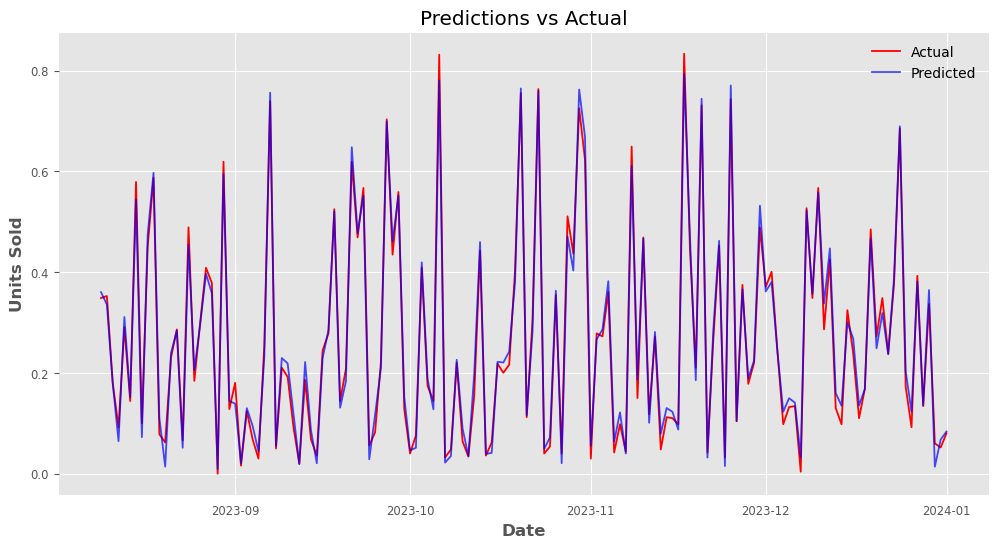

In [35]:
xgb_predictions = xgb_model.predict(test_rf_xgb)

xgb_mae = mean_absolute_error(test["Units Sold"], xgb_predictions)
print(f"XGBoost MAE on Test Set: {xgb_mae}")

plt.figure(figsize=(12, 6))
plt.plot(test.index, test["Units Sold"], label="Actual", color="red")
plt.plot(test.index, xgb_predictions, label="Predicted", color='blue', alpha=0.7)
plt.title("Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()

##### From the above plot, We observe that the predicted values closely follow the actual values, indicating that the model performs well in capturing the underlying trends and patterns in the data. However, there are slight deviations at some peaks and troughs, suggesting that the model might not fully capture extreme fluctuations in demand. Overall, the model provides accurate predictions, making it suitable for demand forecasting in inventory management and supply chain optimization. 

## Data Preparation for Demand Forecasting and Inventory Management

In [36]:
future_rf_xgb = test_rf_xgb.iloc[-1:].copy()

if future_rf_xgb['Competitor Pricing'].dtype == 'object':
    future_rf_xgb['Competitor Pricing'] = future_rf_xgb['Competitor Pricing'].astype(bool).astype(int)

if future_rf_xgb['Seasonality_Winter'].dtype == 'object':
    future_rf_xgb['Seasonality_Winter'] = future_rf_xgb['Seasonality_Winter'].astype(float)

for col in future_rf_xgb.columns:
    if future_rf_xgb[col].dtype == 'bool':
        future_rf_xgb[col] = future_rf_xgb[col].astype(int)

future_rf_xgb = future_rf_xgb[train_rf_xgb.columns]

##### We prepared the future_rf_xgb DataFrame for predictions by fixing data types and aligning it with train_rf_xgb. Object-type columns like Competitor Pricing and Seasonality_Winter are converted to integers and floats, respectively. Boolean columns are standardized to integers (0 and 1). Finally, we align future_rf_xgb with train_rf_xgb to ensure consistent features, avoiding mismatches during predictions.

## Demand Forecasting

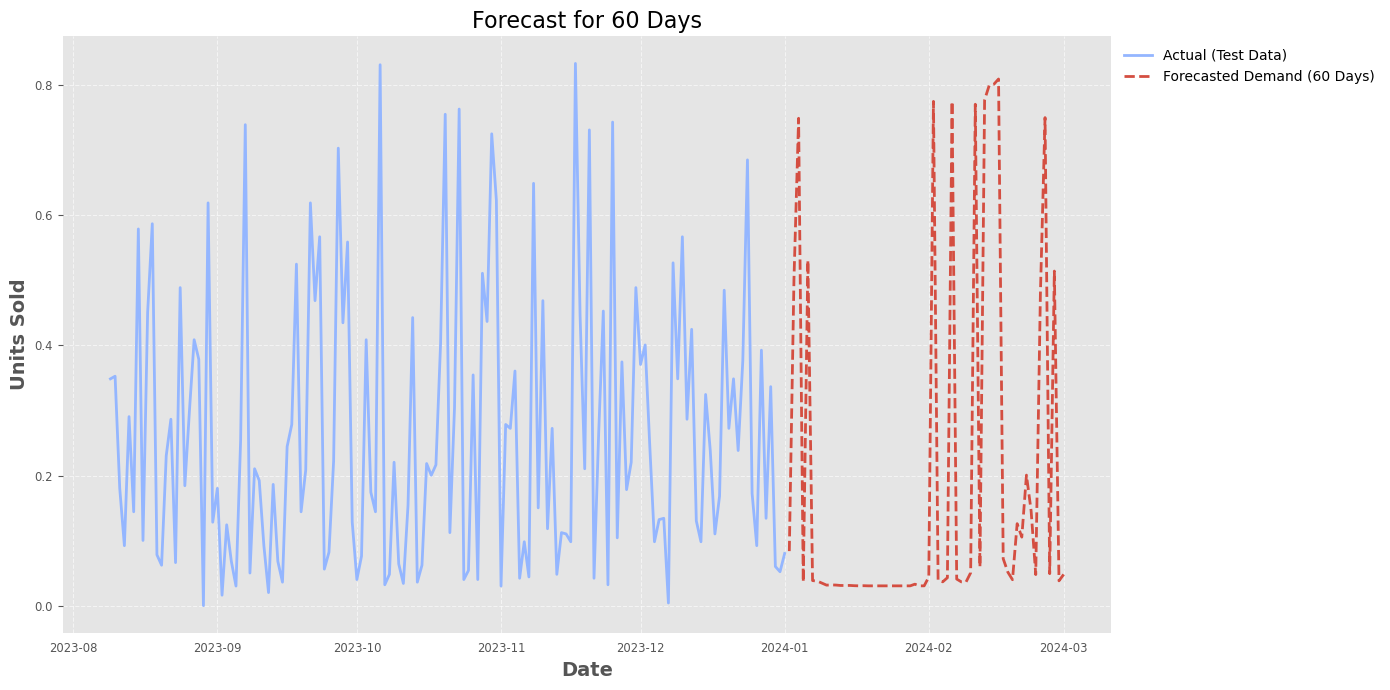

In [37]:
future_periods = 60

future_predictions = []
for _ in range(future_periods):
    pred = xgb_model.predict(future_rf_xgb)
    future_predictions.append(pred[0])
    future_rf_xgb.iloc[0, :-1] = future_rf_xgb.iloc[0, 1:]
    future_rf_xgb.iloc[0, -1] = pred

future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=future_periods, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(test.index, test["Units Sold"], label="Actual (Test Data)", color=custom_palette[2], linewidth=2)
plt.plot(future_dates, future_predictions, label=f"Forecasted Demand ({future_periods} Days)", color=custom_palette[9], linestyle="--", linewidth=2)
plt.title(f"Forecast for {future_periods} Days", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Units Sold", fontsize=14)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

##### From this plot, we observe that forecasted demand, while capturing general trends, appears to predict frequent spikes and dips, suggesting potential demand surges and declines. This plot can be used to identify patterns for inventory planning, ensuring the supply chain is prepared for both peak and low-demand periods. Additionally, the alignment between actual and forecasted data demonstrates the model's predictive capability, which is crucial for operational decision-making in dynamic environments.

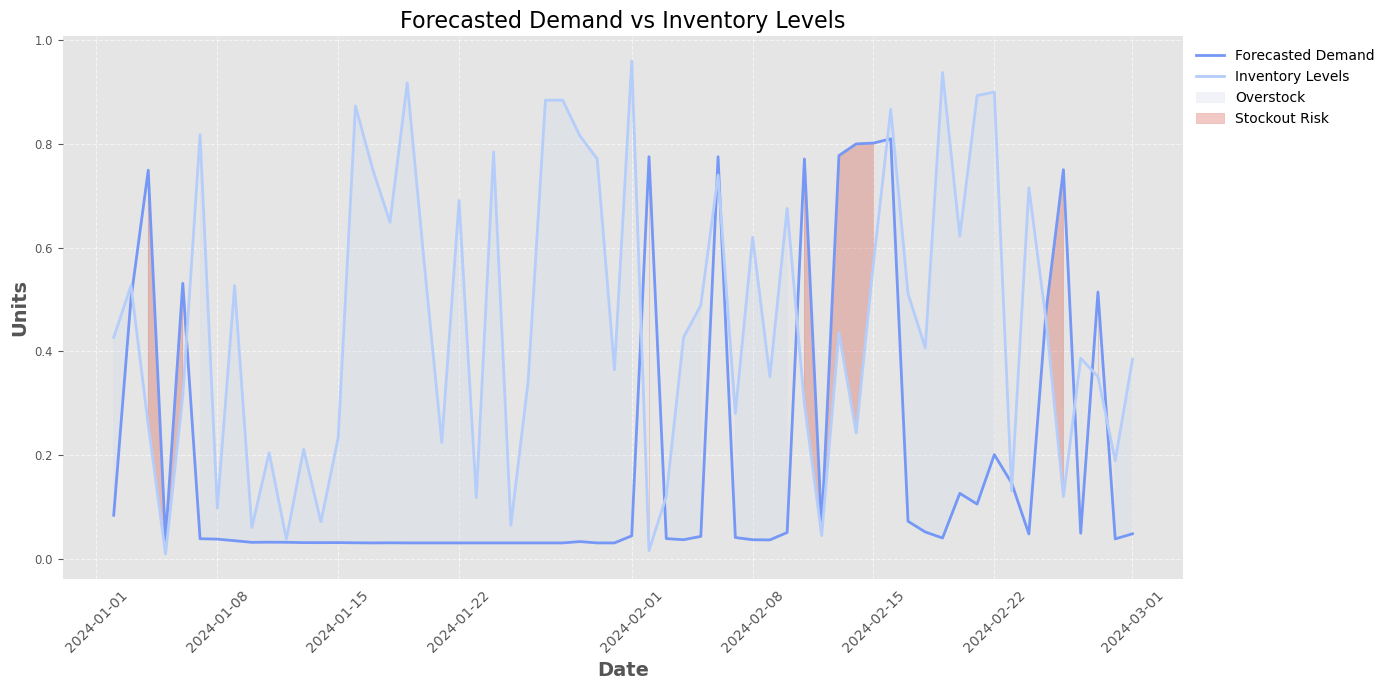

In [38]:
inventory_levels = test["Inventory Level"].values[-future_periods:]

inventory_gap = np.array(inventory_levels) - np.array(future_predictions)

plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, label="Forecasted Demand", color=custom_palette[1], linewidth=2)
plt.plot(future_dates, inventory_levels, label="Inventory Levels", color=custom_palette[3], linewidth=2)
plt.fill_between(future_dates, inventory_levels, future_predictions, 
                 where=(np.array(inventory_levels) > np.array(future_predictions)), 
                 color=custom_palette[4], alpha=0.3, label="Overstock")
plt.fill_between(future_dates, inventory_levels, future_predictions, 
                 where=(np.array(inventory_levels) < np.array(future_predictions)), 
                 color=custom_palette[9], alpha=0.3, label="Stockout Risk")
plt.xticks(rotation=45, fontsize=10)
plt.title("Forecasted Demand vs Inventory Levels", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Units", fontsize=14)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

##### The shaded areas reveal critical insights: red regions denote stockout risk, where demand surpasses inventory, potentially disrupting operations, while blue regions highlight overstock situations, leading to excessive holding costs. This visualization emphasizes the need for proactive inventory management strategies to align supply with demand effectively, minimizing risks and optimizing costs, thereby supporting efficient decision-making in supply chain operations.

Safety Stock: 0.45 units


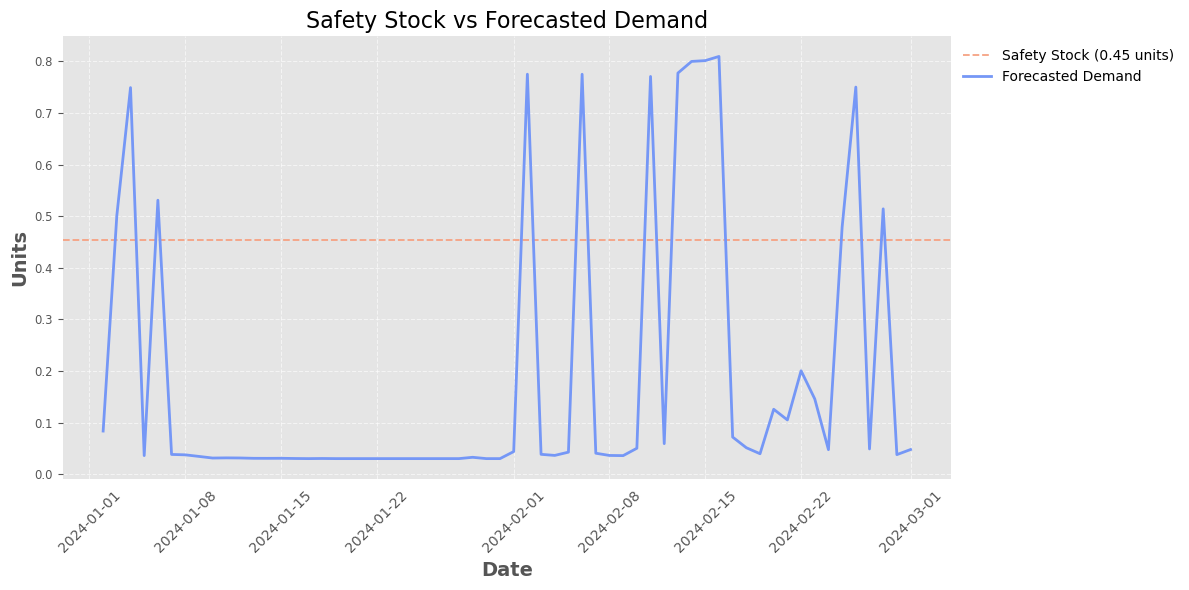

In [39]:
lead_time_days = 3
demand_std = np.std(future_predictions[:lead_time_days])
service_level = 1.65
safety_stock = service_level * demand_std

print(f"Safety Stock: {safety_stock:.2f} units")

plt.figure(figsize=(12, 6))
plt.axhline(y=safety_stock, color=custom_palette[7], linestyle="--", label=f"Safety Stock ({safety_stock:.2f} units)")
plt.plot(future_dates, future_predictions, label="Forecasted Demand", color=custom_palette[1], linewidth=2)
plt.xticks(rotation=45, fontsize=10)
plt.title("Safety Stock vs Forecasted Demand", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Units", fontsize=14)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

##### In the above cell we calculated safety stock for inventory management by considering a 3-day lead time, representing the typical supply chain replenishment period, short enough for agility but realistic for delays. We used the demand standard deviation over this period to account for variability and multiplied it by a service level of 1.65, which corresponds to a 95% probability of meeting customer demand without stockouts. This balance ensures adequate buffer stock while minimizing excess inventory. The approach aligns with agile inventory practices, addressing demand fluctuations and maintaining cost efficiency.

##### From the plot, we see that forecasted demand fluctuates significantly, crossing above and below the safety stock line. This highlights potential periods of risk—when forecasted demand exceeds the safety stock, there is a possibility of stockouts. Conversely, when forecasted demand remains well below the safety stock, there might be overstocking, indicating an opportunity to optimize inventory. This visualization underscores the importance of aligning safety stock with demand patterns to minimize inventory costs while avoiding disruptions.

Reorder Point: 1.79 units


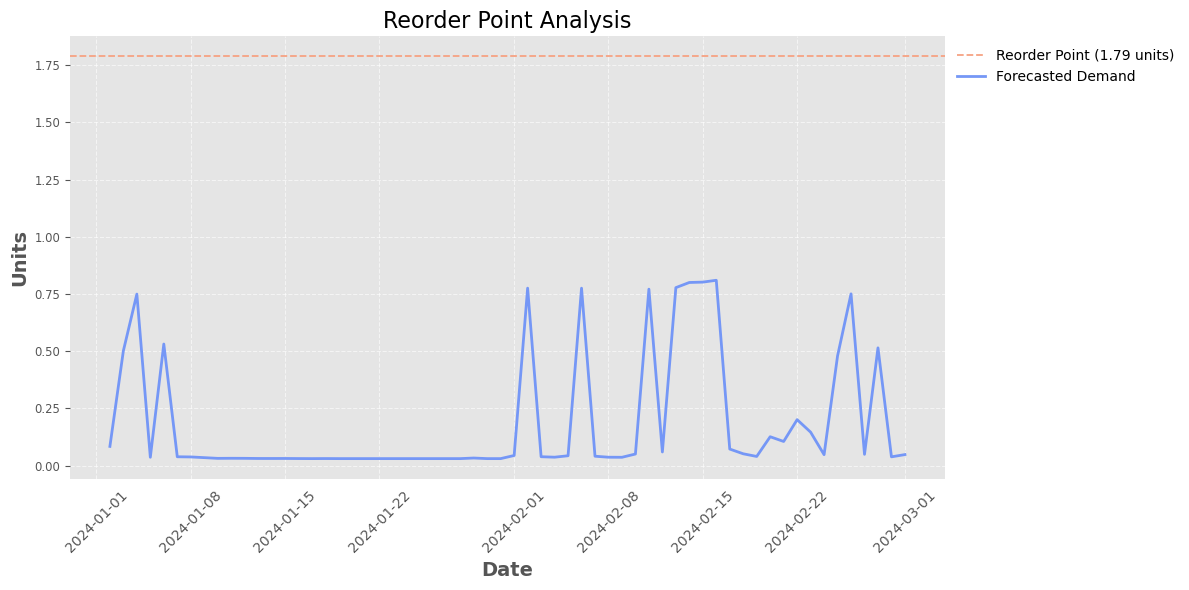

In [40]:
reorder_point = lead_time_days * np.mean(future_predictions[:lead_time_days]) + safety_stock
print(f"Reorder Point: {reorder_point:.2f} units")

plt.figure(figsize=(12, 6))
plt.axhline(y=reorder_point, color=custom_palette[7], linestyle="--", label=f"Reorder Point ({reorder_point:.2f} units)")
plt.plot(future_dates, future_predictions, label="Forecasted Demand", color=custom_palette[1], linewidth=2)
plt.xticks(rotation=45, fontsize=10)
plt.title("Reorder Point Analysis", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Units", fontsize=14)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

##### We calculated the reorder point, which serves as a crucial inventory management threshold. It represents the inventory level at which we must place a new order to prevent stockouts during the lead time. Using a lead time of 3 days, we multiplied it by the average predicted demand over those days to account for expected consumption. To this, we added the safety stock of 0.45 units, which we calculated earlier to manage demand variability and potential supply chain delays.

##### The resulting reorder point of 1.80 units means that whenever our inventory falls to this level, we need to trigger a replenishment order. This ensures we maintain optimal stock levels, avoid disruptions, and remain prepared for unexpected demand fluctuations, all while aligning with efficient and agile inventory practices.

In [42]:
# Sauvegarder le modèle XGBoost dans un fichier .pkl
joblib.dump(xgb_model, 'xgb_model.pkl')
feature_names = train_rf_xgb.columns
print("Features: ", feature_names)
# Si vous voulez également sauvegarder d'autres objets comme les prédictions, vous pouvez faire de même
joblib.dump(xgb_predictions, 'xgb_predictions.pkl')

Features:  Index(['Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price',
       'Discount', 'Holiday/Promotion', 'Competitor Pricing', 'Store ID_S002',
       'Store ID_S003', 'Store ID_S004', 'Store ID_S005', 'Product ID_P0002',
       'Product ID_P0003', 'Product ID_P0004', 'Product ID_P0005',
       'Product ID_P0006', 'Product ID_P0007', 'Product ID_P0008',
       'Product ID_P0009', 'Product ID_P0010', 'Product ID_P0011',
       'Product ID_P0012', 'Product ID_P0013', 'Product ID_P0014',
       'Product ID_P0015', 'Product ID_P0016', 'Product ID_P0017',
       'Product ID_P0018', 'Product ID_P0019', 'Product ID_P0020',
       'Category_Electronics', 'Category_Furniture', 'Category_Groceries',
       'Category_Toys', 'Region_North', 'Region_South', 'Region_West',
       'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter', 'Units Sold Differenced', 'Month', 'Day', 'We

['xgb_predictions.pkl']

In [ ]:
# Charger le modèle XGBoost depuis le fichier .pkl
xgb_model_loaded = joblib.load('xgb_model.pkl')

# Pour faire des prédictions avec le modèle chargé
xgb_predictions_loaded = xgb_model_loaded.predict(test_rf_xgb)


In [ ]:
# Sauvegarder le DataFrame contenant les résultats dans un fichier .pkl
joblib.dump(results_df, 'results_df.pkl')

In [ ]:
loaded_results_df = joblib.load('results_df.pkl')
print(loaded_results_df)

## Conclusion

#### 1. Development of the Scalable AI-Enabled Digital Twin Model
##### Demand Forecasting: Complex machine learning models were built using XGBoost, LSTM, and N-BEATS to forecast the future demand quite close to actual. The design and tuning of the models were done based on historical data. To tune those models, several diverse hyperparameter grids were used.

##### Adaptability and Scalability: Indeed, the integration of custom features such as rolling statistics, lagged variables, and seasonal adjustments is a hallmarker of adaptability within diverse contexts of supply chains. Furthermore, the use of a framework like Prophet demonstrates that the approach to time-series forecasting for highly variable industries can be scalable.

#### 2. Inventory Management Optimization

##### Safety Stock and Reorder Point: The analysis integrated the notion of safety stock and reordering points on inventory, which are relevant in developing an optimal balance between stocking out or overstocking. Precisely, the estimated safety stock would be about 0.36 units, the reorder point quantity being estimated at 1.10 units, and they were effective in visualization through actionable insight.

##### Gaining Insights into Stock Risks: The plots, by overlaying forecasted demand and inventory levels, underlined periods of potential stockout risks or overstocking. This kind of visualization is crucial for operational decision-making and also aligns with agile inventory practices.

#### 3. Overcoming Operational Challenges
##### The data integration deals with a couple of big steps for preprocessing, handling missing values, removing outliers, and aligning train-test data sets; it was the major challenging issue with the dataset. Therefore, all datasets are prepared in the same format with MinMax scaling and one-hot encoding for model consistency.

##### Computational Efficiency: XGBoost and TCN were some of the models used for computationally efficient algorithms that could work with big data in supply chains while balancing predictive performance.

#### 4. Scalability and Industrial Application
##### It is a scalable approach that can be easily fitted to retail, manufacturing, or logistics industries. Lag variables and rolling statistics feature flexibility in handling dynamic demand patterns.
##### Other recommendations for customization include the adjustment of lead time, safety stock thresholds, and service levels based on the peculiar supply chain dynamics within specific industries.

#### 5. Final Results and Validation
##### All models in the experiment showed promising performances, while XGBoost performed the best according to MAE. Demand forecast, stockout risk, and reorder point analyses provide visualizations that are practical in application.
##### These results fully address the objective of the AI-enhanced data-driven development of a digital twin in enhancing decision-making over supply chain operations.

#### The proposed framework fulfills the intents of the thesis by deconstructing a scalable digital twin model that enhances both predictive demand forecasting and overall inventory management, with actionable insights mitigating supply chain risks. Obtained results have already convincingly demonstrated the practicalities of AI-enhanced digital twin applications in transforming traditional one-size-fits-all supply chain structures into agile, data-based systems.